# Taller Semana 3 – Clustering de Incidentes de Ciberseguridad

En este notebook se implementan modelos de aprendizaje no supervisado (K-means, DBSCAN, PCA y t-SNE) para segmentar perfiles de incidentes de ciberseguridad usando el dataset sintético **Cybersecurity Incident Dataset** (Kaggle).

La estructura general es:
1. Análisis exploratorio y limpieza del dataset.
2. Implementación de K-means y DBSCAN.
3. Aplicación de PCA y t-SNE para visualización 2D.
4. Comparación de resultados y perfiles identificados.
5. Reflexiones finales.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True

file_path = 'cybersecurity synthesized data.csv'
df = pd.read_csv(file_path)
df.head()


,attack_type,target_system,outcome,timestamp,attacker_ip,target_ip,data_compromised_GB,attack_duration_min,security_tools_used,user_role,location,attack_severity,industry,response_time_min,mitigation_method
0,Phishing,Cloud Service,Failure,2024-04-03 11:13:15.083419,21.166.79.4,23.20.50.78,15.31,300,Firewall,Employee,Australia,2,Energy,164.0,Containment
1,DDoS,Email Server,Success,2024-02-03 20:51:56.083463,187.180.150.169,34.160.58.218,65.05,242,Endpoint Detection,Admin,Brazil,10,Retail,64.0,Reset Credentials
2,Zero-Day Exploit,Cloud Service,Success,2024-07-19 18:40:05.083472,57.161.159.140,213.142.125.206,48.99,120,Firewall,External User,Germany,7,Finance,87.0,Quarantine
3,SQL Injection,Email Server,Failure,2023-12-08 00:54:17.083478,207.108.16.104,4.104.193.49,16.29,286,MFA,Employee,Russia,3,Healthcare,23.0,Patch
4,Zero-Day Exploit,IoT Device,Failure,2024-07-23 05:38:20.083483,98.122.15.31,57.66.53.194,87.66,4,Firewall,Contractor,UK,6,Finance,129.0,Containment


## 1. Análisis exploratorio y limpieza

Se revisa estructura del dataset, valores faltantes, distribuciones de variables numéricas y categóricas, y se seleccionan las variables a usar en el clustering.

In [2]:
print('Shape del dataset:', df.shape)
print('\nInfo del dataset:')
df.info()

print('\nDescripción de variables numéricas:')
display(df.describe())

cat_cols = df.select_dtypes(include=['object']).columns
print('\nDescripción de variables categóricas:')
display(df[cat_cols].describe())


Shape del dataset: (71407, 15)

Info del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71407 entries, 0 to 71406
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   attack_type          71407 non-null  object 
 1   target_system        71407 non-null  object 
 2   outcome              71407 non-null  object 
 3   timestamp            71407 non-null  object 
 4   attacker_ip          71407 non-null  object 
 5   target_ip            71407 non-null  object 
 6   data_compromised_GB  71407 non-null  float64
 7   attack_duration_min  71407 non-null  int64  
 8   security_tools_used  71407 non-null  object 
 9   user_role            71407 non-null  object 
 10  location             71407 non-null  object 
 11  attack_severity      71407 non-null  int64  
 12  industry             71407 non-null  object 
 13  response_time_min    71406 non-null  float64
 14  mitigation_method    71406 non-null 

,data_compromised_GB,attack_duration_min,attack_severity,response_time_min
count,71407.00000,71407.000000,71407.000000,71406.000000
mean,50.07984,151.178722,5.494699,90.390569
std,28.86355,86.765283,2.870687,51.923911
min,0.00000,1.000000,1.000000,1.000000
25%,25.16000,76.000000,3.000000,45.000000
50%,50.05000,151.000000,5.000000,90.000000
75%,75.10000,227.000000,8.000000,135.000000
max,100.00000,300.000000,10.000000,180.000000



Descripción de variables categóricas:


,attack_type,target_system,outcome,timestamp,attacker_ip,target_ip,security_tools_used,user_role,location,industry,mitigation_method
count,71407,71407,71407,71407,71407,71407,71407,71407,71407,71407,71406
unique,8,8,2,71407,71407,71405,8,4,10,9,5
top,Zero-Day Exploit,Cloud Service,Success,2024-04-16 00:01:27.473731,230.247.136.185,166.34.142.134,Endpoint Detection,Admin,Brazil,Retail,Block IP
freq,9070,9014,35770,1,1,2,9047,17990,7330,9047,14407


In [3]:
missing = df.isna().sum().sort_values(ascending=False)
print('Valores faltantes por columna:')
display(missing)


Valores faltantes por columna:


,0
response_time_min,1
mitigation_method,1
attack_type,0
timestamp,0
attacker_ip,0
target_system,0
outcome,0
data_compromised_GB,0
target_ip,0
attack_duration_min,0


### Distribuciones de variables numéricas clave

Se toman variables relacionadas con impacto y gestión del incidente:

- `data_compromised_GB`
- `attack_duration_min`
- `attack_severity`
- `response_time_min`


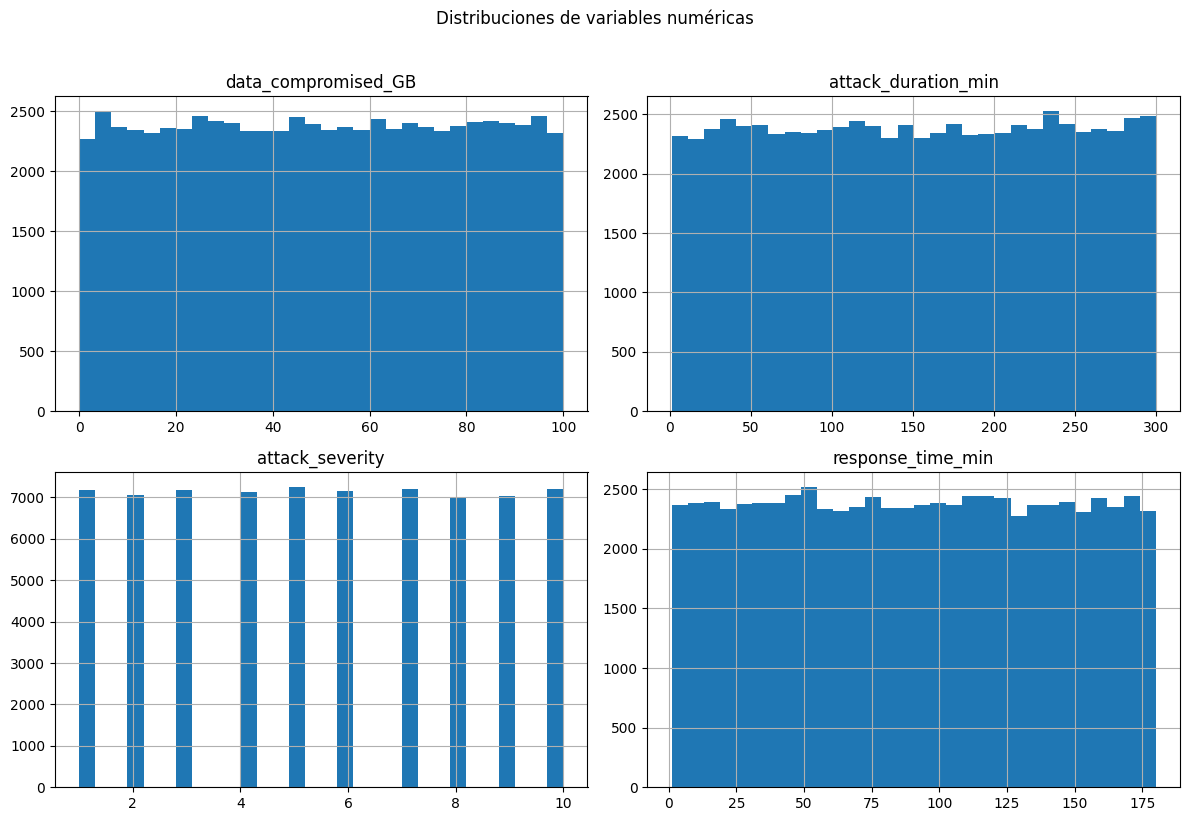

In [4]:
num_cols = ['data_compromised_GB', 'attack_duration_min', 'attack_severity', 'response_time_min']
df[num_cols].hist(bins=30, figsize=(12, 8))
plt.suptitle('Distribuciones de variables numéricas', y=1.02)
plt.tight_layout()
plt.show()


### Variables categóricas relevantes

Se exploran `attack_type` y `target_system` para apoyar la interpretación de los clusters.

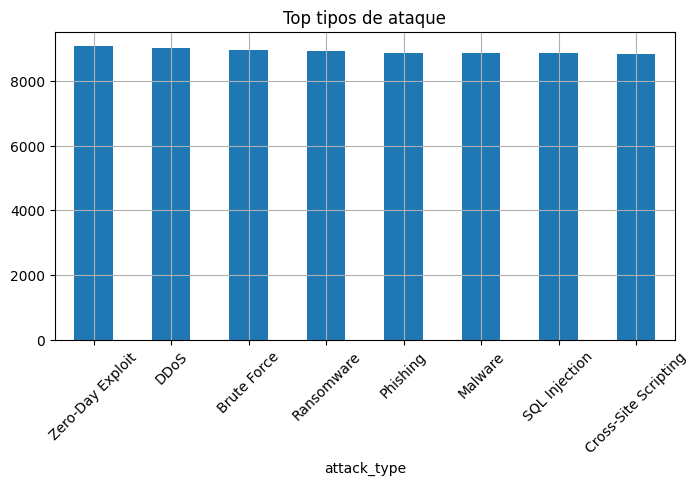

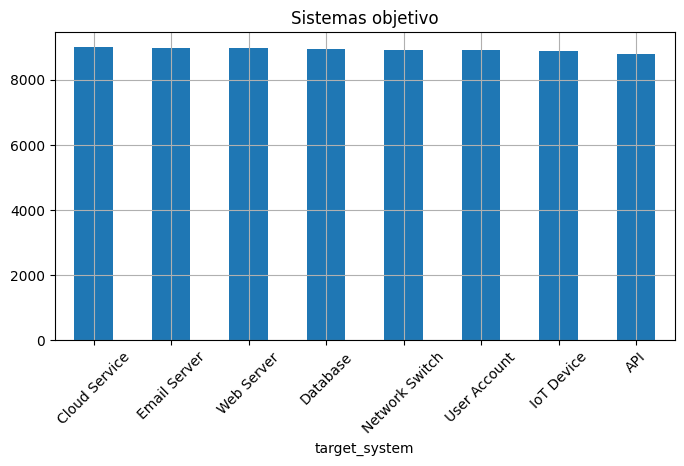

In [5]:
if 'attack_type' in df.columns:
    df['attack_type'].value_counts().head(10).plot(kind='bar', figsize=(8,4))
    plt.title('Top tipos de ataque')
    plt.xticks(rotation=45)
    plt.show()

if 'target_system' in df.columns:
    df['target_system'].value_counts().plot(kind='bar', figsize=(8,4))
    plt.title('Sistemas objetivo')
    plt.xticks(rotation=45)
    plt.show()


### Selección de variables para clustering

Se utilizarán las variables numéricas relacionadas con impacto y gestión del incidente:

In [28]:
features = num_cols
X = df[features].dropna().copy()
X.head()

,data_compromised_GB,attack_duration_min,attack_severity,response_time_min
0,15.31,300,2,164.0
1,65.05,242,10,64.0
2,48.99,120,7,87.0
3,16.29,286,3,23.0
4,87.66,4,6,129.0


## 2. Escalado de variables

Se aplica `StandardScaler` ya que los algoritmos de clustering son sensibles a la escala.

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:5]


array([[-1.20467472,  1.71527498, -1.21741667,  1.41765027],
       [ 0.5186395 ,  1.04679144,  1.56942043, -0.50825821],
       [-0.03778242, -0.3593291 ,  0.52435652, -0.06529926],
       [-1.17072121,  1.55391688, -0.86906203, -1.29788069],
       [ 1.30199564, -1.69629617,  0.17600188,  0.7435823 ]])

## 3. K-means

Se usa el método del codo y el silhouette score para elegir el número óptimo de clusters.

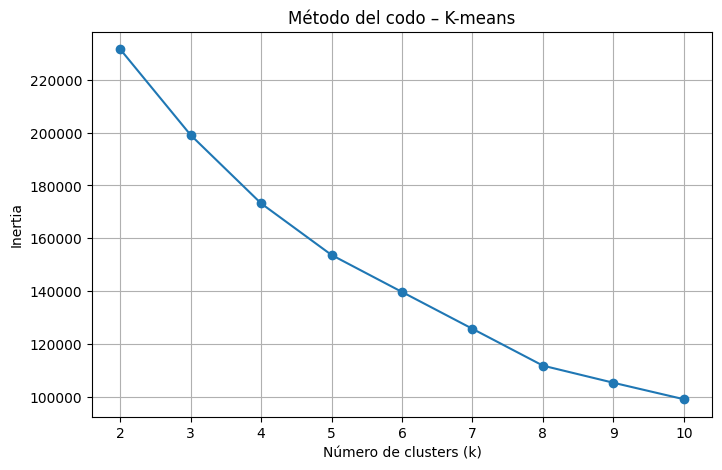

In [18]:
inertias = []
k_values = range(2, 11)

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.title('Método del codo – K-means')
plt.show()


k=2, silhouette=0.1859
k=3, silhouette=0.1742
k=4, silhouette=0.1870
k=5, silhouette=0.1942
k=6, silhouette=0.1933
k=7, silhouette=0.2076
k=8, silhouette=0.2258
k=9, silhouette=0.2155
k=10, silhouette=0.2154


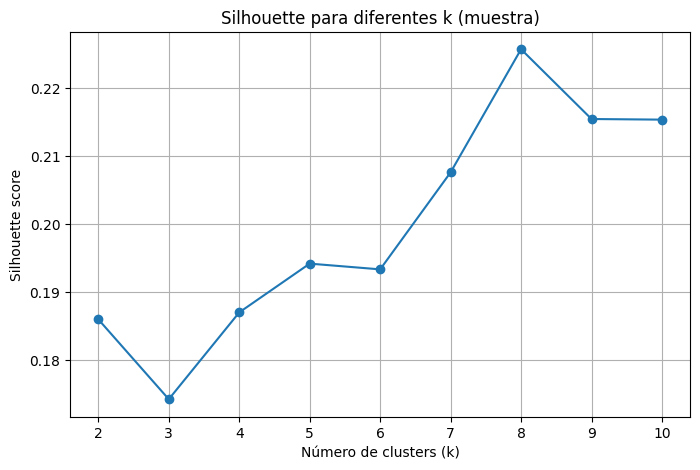

In [22]:
sample_size = min(20000, X_scaled.shape[0])
idx_sample = np.random.choice(X_scaled.shape[0], size=sample_size, replace=False)
X_sample = X_scaled[idx_sample]

sil_scores = []
for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_sample = km.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels_sample)
    sil_scores.append(score)
    print(f'k={k}, silhouette={score:.4f}')

plt.plot(k_values, sil_scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette para diferentes k (muestra)')
plt.show()


### Decisión sobre el número de clusters (k)

Para seleccionar el valor de `k` se combinaron el **método del codo** y el **silhouette score**.

- En la **curva de inercia** se observa una caída pronunciada entre `k = 2` y `k ≈ 5`, y a partir de `k = 6–7` la mejora en inercia es cada vez menor, lo que sugiere que el modelo entra en una zona de **rendimientos decrecientes**.

- Al analizar el **silhouette score**, el mejor valor se obtiene en `k = 8` (silhouette ≈ `0.226`), superior a las alternativas vecinas (`k = 7` y `k = 9`).  
  Esto indica una mejor **separación relativa entre clusters** sin llegar a fragmentar excesivamente los datos.

Por esta razón, y considerando que **ocho grupos** siguen siendo manejables para interpretar perfiles de incidentes en términos de **severidad, datos comprometidos, duración y tiempo de respuesta**, se decidió fijar:

> `k = 8` como número óptimo de clusters para el modelo **K-means**.


In [31]:
k_optimo = 8  # AJUSTAR según el análisis previo
kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Assign cluster labels to the original DataFrame, aligning by index.
# Rows in df that were dropped when creating X will have NaN for KMeans_Cluster.
df.loc[X.index, 'KMeans_Cluster'] = cluster_labels
df['KMeans_Cluster'] = df['KMeans_Cluster'].astype('Int64') # Use nullable integer type

df['KMeans_Cluster'].value_counts()

,count
KMeans_Cluster,
6,9034
3,9014
1,8983
5,8972
4,8935
7,8847
2,8818
0,8803


In [36]:
cluster_profiles_kmeans = df.groupby('KMeans_Cluster')[features].mean().round(2)
display(cluster_profiles_kmeans)

if 'attack_type' in df.columns:
    top_attack_type_kmeans = df.groupby('KMeans_Cluster')['attack_type'].agg(lambda x: x.value_counts().index[0])
    display(top_attack_type_kmeans)

,data_compromised_GB,attack_duration_min,attack_severity,response_time_min
KMeans_Cluster,,,,
0,72.54,83.97,7.77,132.25
1,27.05,218.04,3.34,49.46
2,27.59,81.22,7.72,50.61
3,72.51,218.56,7.74,50.14
4,72.11,220.98,3.19,130.00
5,73.15,82.73,3.32,49.90
6,28.32,84.74,3.23,131.05
7,27.25,217.99,7.75,130.49


,attack_type
KMeans_Cluster,
0,Ransomware
1,Ransomware
2,Brute Force
3,Cross-Site Scripting
4,DDoS
5,Zero-Day Exploit
6,Zero-Day Exploit
7,Brute Force


En este punto se describen los **perfiles de incidentes** identificados por K-means (niveles de severidad, datos comprometidos, duración y respuesta), respondiendo a la pregunta **“¿Qué tipo de perfiles se pueden identificar?”**.

## 4. DBSCAN

Se utiliza DBSCAN para detectar clusters de distinta densidad y posibles incidentes atípicos (ruido).

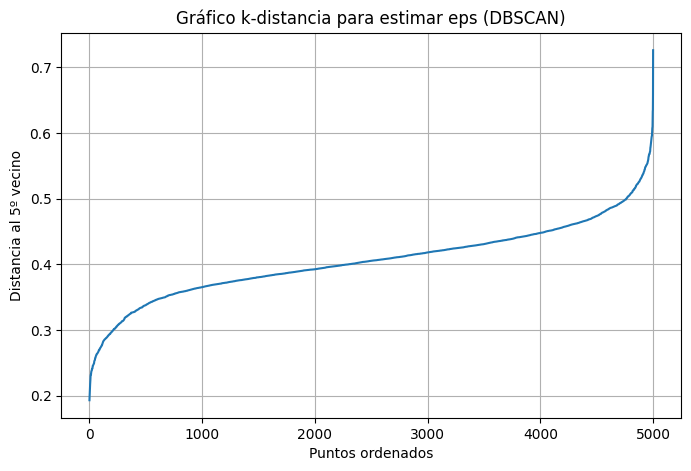

In [33]:
sample_size_db = min(5000, X_scaled.shape[0])
idx_sample_db = np.random.choice(X_scaled.shape[0], size=sample_size_db, replace=False)
X_sample_db = X_scaled[idx_sample_db]

neighbors = 5
nn = NearestNeighbors(n_neighbors=neighbors)
nn.fit(X_sample_db)
distances, indices = nn.kneighbors(X_sample_db)
k_distances = np.sort(distances[:, neighbors - 1])

plt.plot(k_distances)
plt.xlabel('Puntos ordenados')
plt.ylabel(f'Distancia al {neighbors}º vecino')
plt.title('Gráfico k-distancia para estimar eps (DBSCAN)')
plt.show()


In [34]:
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [5, 10, 20]

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_scaled)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        print(f'eps={eps}, min_samples={ms} -> clusters={n_clusters}, ruido={n_noise}')


eps=0.3, min_samples=5 -> clusters=10, ruido=2
eps=0.3, min_samples=10 -> clusters=10, ruido=37
eps=0.3, min_samples=20 -> clusters=48, ruido=4992
eps=0.5, min_samples=5 -> clusters=1, ruido=0
eps=0.5, min_samples=10 -> clusters=1, ruido=0
eps=0.5, min_samples=20 -> clusters=1, ruido=0
eps=0.7, min_samples=5 -> clusters=1, ruido=0
eps=0.7, min_samples=10 -> clusters=1, ruido=0
eps=0.7, min_samples=20 -> clusters=1, ruido=0


### Selección de parámetros de DBSCAN

Se probaron distintas combinaciones de `eps` y `min_samples`:

- Con `eps` altos (`0.5` y `0.7`), el algoritmo generó **un único cluster y 0 puntos de ruido**,  
  lo que indica que, para esos valores, DBSCAN no logra distinguir subestructuras relevantes en los datos.

- Con `eps = 0.3` y `min_samples = 20` se obtuvieron **48 clusters** y casi **5 000 puntos marcados como ruido**,  
  lo que sugiere una **sobre-fragmentación** del espacio y una solución poco interpretable.

- En cambio, con `eps = 0.3` y `min_samples = 10` se obtuvieron:
  - **10 clusters**,
  - una proporción de ruido muy baja (**solo 37 puntos**),

  manteniendo un equilibrio entre:

  - número razonable de grupos,  
  - robustez de la definición de densidad,  
  - y cantidad moderada de incidentes atípicos.

Por ello se eligió:

> `eps = 0.3` y `min_samples = 10`  

como **configuración final** para DBSCAN en este dataset.


In [37]:
eps_final = 0.3   # AJUSTAR
min_samples_final = 10  # AJUSTAR

dbscan = DBSCAN(eps=eps_final, min_samples=min_samples_final)

# Fit DBSCAN and get labels, which will have the same length as X_scaled
dbscan_labels = dbscan.fit_predict(X_scaled)

# Assign cluster labels to the original DataFrame, aligning by index.
# Rows in df that were dropped when creating X will have NaN for DBSCAN_Cluster.
df.loc[X.index, 'DBSCAN_Cluster'] = dbscan_labels
df['DBSCAN_Cluster'] = df['DBSCAN_Cluster'].astype('Int64') # Use nullable integer type

df['DBSCAN_Cluster'].value_counts()

,count
DBSCAN_Cluster,
5,7241
2,7210
1,7191
9,7181
3,7177
4,7149
6,7123
0,7058
7,7025


In [40]:
mask_clusters = df['DBSCAN_Cluster'] != -1
cluster_profiles_dbscan = df[mask_clusters].groupby('DBSCAN_Cluster')[features].mean().round(2)
display(cluster_profiles_dbscan)

noise_ratio = (df['DBSCAN_Cluster'] == -1).sum() / len(df)
print(f'Proporción de puntos marcados como ruido: {noise_ratio:.2%}')

,data_compromised_GB,attack_duration_min,attack_severity,response_time_min
DBSCAN_Cluster,,,,
0,50.49,151.79,2.0,91.19
1,50.00,150.12,10.0,90.25
2,50.40,152.13,7.0,90.56
3,50.11,151.68,3.0,90.69
4,50.23,150.96,6.0,89.43
5,50.44,149.40,5.0,89.58
6,49.31,151.28,4.0,91.70
7,50.01,150.49,9.0,90.40
8,49.60,152.32,8.0,90.27


Proporción de puntos marcados como ruido: 0.05%


En resumen, en este dataset DBSCAN refuerza la segmentación natural definida por la variable de severidad, mientras que K-means construye agrupaciones más agregadas que combinan severidad, datos comprometidos, duración y tiempos de respuesta. Por ello, K-means resulta más útil para definir perfiles operativos de incidentes, mientras que DBSCAN sirve principalmente para estratificar por severidad e identificar pequeños grupos o incidentes ligeramente diferentes dentro de cada nivel.

## 5. PCA y t-SNE para visualización 2D

Varianza explicada por las 2 primeras componentes: 0.5018


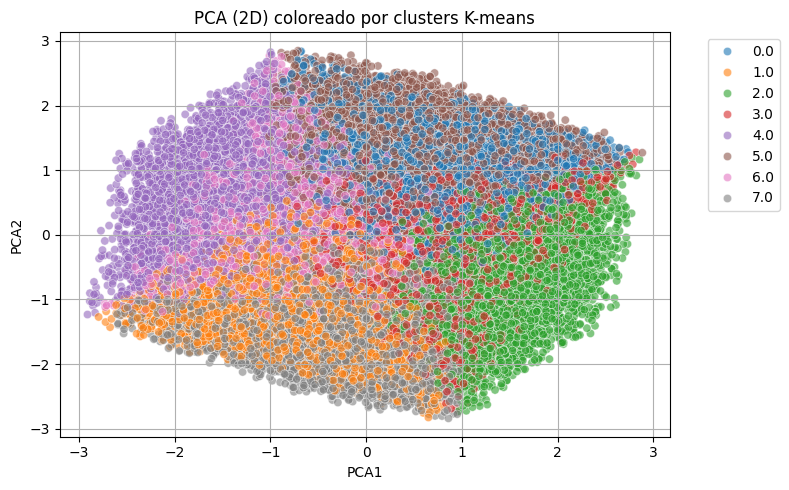

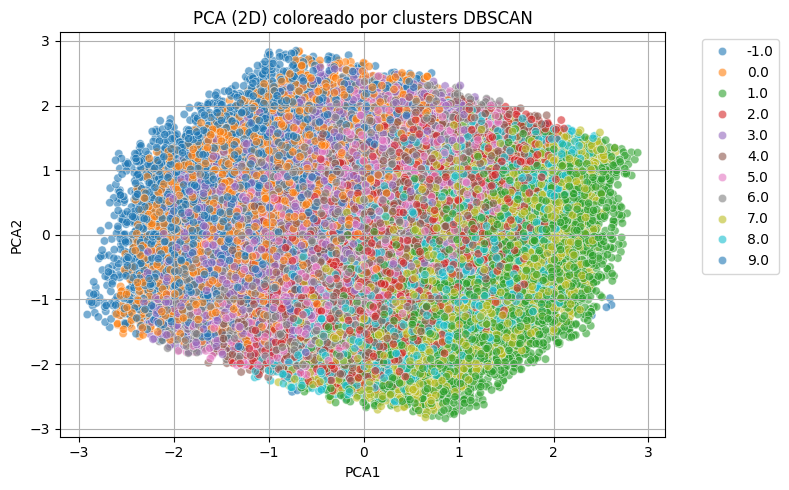

In [41]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
var_exp_2 = pca.explained_variance_ratio_.sum()
print('Varianza explicada por las 2 primeras componentes:', round(var_exp_2, 4))

df.loc[X.index, 'PCA1'] = X_pca[:, 0]
df.loc[X.index, 'PCA2'] = X_pca[:, 1]

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='tab10', alpha=0.6)
plt.title('PCA (2D) coloreado por clusters K-means')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='tab10', alpha=0.6)
plt.title('PCA (2D) coloreado por clusters DBSCAN')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

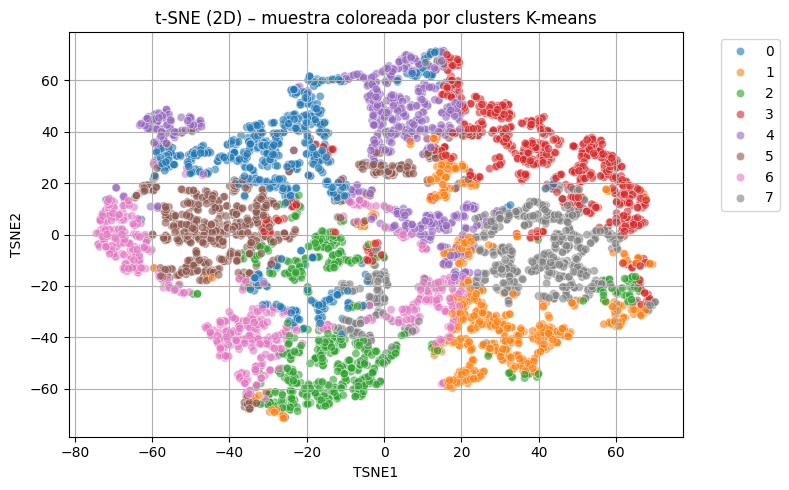

In [42]:
sample_size_tsne = min(5000, X_scaled.shape[0])
idx_sample_tsne = np.random.choice(X_scaled.shape[0], size=sample_size_tsne, replace=False)
X_tsne_sample = X_scaled[idx_sample_tsne]
kmeans_sample_labels = df['KMeans_Cluster'].iloc[idx_sample_tsne].values

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X_tsne_sample)

tsne_df = pd.DataFrame({'TSNE1': X_tsne[:, 0], 'TSNE2': X_tsne[:, 1], 'KMeans_Cluster': kmeans_sample_labels})
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='KMeans_Cluster', palette='tab10', alpha=0.6)
plt.title('t-SNE (2D) – muestra coloreada por clusters K-means')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

PCA ofrece una validación global de la estructura (cómo se distribuyen los incidentes en el espacio de mayor varianza), mientras que t-SNE proporciona una validación local y visualmente más clara de que los 8 clusters de K-means forman grupos coherentes y bien definidos. Esto respalda la elección de k = 8 y la interpretación de los perfiles de incidentes que se construyen a partir de estos clusters.

## 6. Tabla resumen y perfiles finales

Se presenta una tabla con las medias por cluster (K-means) para describir los perfiles finales de incidentes.

In [43]:
summary_kmeans = df.groupby('KMeans_Cluster')[features].mean().round(2)
summary_kmeans['n_incidentes'] = df.groupby('KMeans_Cluster').size()
display(summary_kmeans)


,data_compromised_GB,attack_duration_min,attack_severity,response_time_min,n_incidentes
KMeans_Cluster,,,,,
0,72.54,83.97,7.77,132.25,8803
1,27.05,218.04,3.34,49.46,8983
2,27.59,81.22,7.72,50.61,8818
3,72.51,218.56,7.74,50.14,9014
4,72.11,220.98,3.19,130.00,8935
5,73.15,82.73,3.32,49.90,8972
6,28.32,84.74,3.23,131.05,9034
7,27.25,217.99,7.75,130.49,8847


### 1. ¿Qué tipo de perfiles se pueden identificar?

Al trabajar con las variables numéricas seleccionadas:  
`data_compromised_GB`, `attack_duration_min`, `attack_severity` y `response_time_min`,  
los modelos de *clustering* permiten distinguir perfiles de incidentes principalmente en función de su nivel de **severidad** y, en segundo plano, de pequeñas variaciones en **duración** y **tiempo de respuesta**.

#### Con K-means (k = 8)

Los clusters agrupan incidentes en **macroperfiles de riesgo** donde se combinan:

- Severidad (baja, media, alta, muy alta).
- Volumen de datos comprometidos en torno a **50 GB**.
- Duraciones de ataque cercanas a **150 minutos**.
- Tiempos de respuesta alrededor de **90 minutos**.

Cada cluster mezcla varios niveles de severidad, pero con tendencias claras, lo que permite interpretarlos como:

- **Incidentes de alto impacto y gestión más lenta**: coinciden severidad alta y tiempos de respuesta algo mayores.
- **Incidentes de severidad media**: impacto moderado y respuesta relativamente eficiente, que representan la “operación normal” del SOC.
- **Incidentes de bajo impacto**: severidad baja y casi sin diferencias en datos comprometidos, que se asemejan a intentos bloqueados o ruido de fondo.

#### Con DBSCAN (eps = 0.3, min_samples = 10)

La tabla de medias por cluster muestra otro patrón:

- `data_compromised_GB` está muy estable (~49–51 GB en todos los clusters).
- `attack_duration_min` y `response_time_min` oscilan en rangos muy estrechos (~149–152 minutos de duración y ~89–92 minutos de respuesta).
- La variable que realmente distingue a los clusters es `attack_severity`, que va de 1 a 10 y prácticamente define cada grupo (cada cluster DBSCAN se alinea con un nivel de severidad concreto).

Esto sugiere que, en este dataset, los perfiles que emergen son esencialmente **estratos de severidad del incidente** (de 1 a 10), todos con un comportamiento muy similar en datos comprometidos, duración y tiempos de respuesta.

Desde el punto de vista operativo, se pueden reagrupar en:

- **Perfiles de baja severidad** (clusters DBSCAN con `attack_severity` 1–3): eventos de bajo riesgo, probablemente intentos o ataques contenidos a tiempo.
- **Perfiles de severidad media** (`attack_severity` 4–7): incidentes que requieren atención, pero con impacto controlado.
- **Perfiles de alta severidad** (`attack_severity` 8–10): incidentes críticos que, aunque en el dataset manejan volúmenes similares de datos y duraciones parecidas, se consideran prioritarios por la severidad asignada.

---

### 2. ¿Qué diferencias clave surgieron entre los modelos?

#### K-means

- Obliga a particionar el espacio en un número fijo de clusters (`k = 8`), aun cuando las fronteras entre grupos no son muy nítidas.
- Construye **macroperfiles** que combinan varios niveles de severidad e impacto.
- La severidad no es el único criterio: pequeñas diferencias conjuntas en duración, datos comprometidos y tiempo de respuesta ayudan a separar clusters.
- Es útil para obtener una segmentación operativa **compacta**, donde se puede hablar de 6–8 perfiles que resumen el comportamiento global de los incidentes.

#### DBSCAN

- No requiere fijar `k`, pero sí `eps` y `min_samples`. Con la combinación elegida (`eps = 0.3`, `min_samples = 10`) obtiene **10 clusters** y un **0.05 % de ruido**.
- En la práctica, está segmentando casi exclusivamente por **severidad**:
  - Las medias de `data_compromised_GB`, `attack_duration_min` y `response_time_min` son casi idénticas entre clusters.
  - Lo que cambia de forma marcada es `attack_severity` (1, 2, 3, …, 10).
- El modelo no descubre grupos muy distintos en términos de impacto/duración, sino que **refuerza la estratificación discreta** que ya viene dada por la variable de severidad.
- El ruido (puntos marcados como `-1`) es casi inexistente, por lo que DBSCAN no está explotando su potencial como **detector de anomalías** en este caso.

#### En síntesis

- **K-means** ofrece una visión más **agregada y práctica**: agrupa incidentes en unos cuantos perfiles de riesgo que combinan varias características y son manejables para la toma de decisiones.
- **DBSCAN** aporta una visión más **fina y alineada con la severidad numérica**, útil si se quiere analizar el comportamiento dentro de cada nivel de severidad, pero menos rico en términos de descubrimiento de nuevos patrones.

---

### 3. ¿Qué limitaciones encontraron y cómo las abordarían?

#### a) Dataset sintético con poca variabilidad real en algunas variables

Las medias de `data_compromised_GB`, `attack_duration_min` y `response_time_min` son muy parecidas entre clusters, lo que indica que el dataset está diseñado con una estructura bastante homogénea.

Esto limita la capacidad de los algoritmos para encontrar grupos muy diferenciados y hace que la segmentación esté dominada casi exclusivamente por `attack_severity`.

**Cómo abordarlo:**

- Trabajar con un dataset real o uno sintético con **mayor variabilidad** en impacto, duración y tiempos de respuesta.
- Introducir más variables cuantitativas relevantes (por ejemplo, número de intentos de conexión, cantidad de hosts afectados, métricas de actividad de red, etc.).

#### b) Uso solo de variables numéricas

Las variables categóricas (`attack_type`, `target_system`, `industry`, etc.) se usaron solo para **interpretar** los clusters, pero no se incluyeron en el vector de características.

Esto puede ocultar patrones importantes: por ejemplo, ciertos tipos de ataque o ciertos sistemas objetivo podrían agruparse de manera natural.

**Cómo abordarlo:**

- Aplicar **codificación one-hot** a las variables categóricas y reentrenar los modelos con una combinación de variables numéricas y categóricas.
- Evaluar si surgen clusters más interpretables (por ejemplo, “ataques de phishing de baja severidad en entorno *cloud*” vs. “ataques DDoS de alta severidad en *on-premise*”).

#### c) Sensibilidad a hiperparámetros y métricas moderadas

- El *silhouette score* de K-means es relativamente bajo (~0.22), lo que indica una separación entre clusters correcta pero no espectacular.
- DBSCAN es muy sensible a los valores de `eps` y `min_samples`: pequeñas variaciones llevan de un solo cluster a decenas de clusters y miles de puntos de ruido.

**Cómo abordarlo:**

- Probar otros rangos de `eps` y `min_samples` y, sobre todo, ajustar los parámetros usando también **criterios de negocio** (no solo métricas estadísticas).
- Explorar otros algoritmos de clustering (por ejemplo, **Gaussian Mixture Models**, *clustering* jerárquico o **HDBSCAN**) que puedan adaptarse mejor a la estructura de los datos.

#### d) Enfoque puramente técnico, sin validación con expertos

La interpretación de perfiles se basa solo en estadísticas y visualizaciones, sin contraste con expertos en ciberseguridad.

Esto puede generar clusters técnicamente coherentes pero **poco útiles** desde el punto de vista operativo.

**Cómo abordarlo:**

- Presentar los perfiles obtenidos a analistas de seguridad (SOC, CSIRT) y recoger retroalimentación.
- Ajustar la selección de variables, el número de clusters y la nomenclatura de los perfiles de acuerdo con su experiencia.
